# TRABALHO 2 - Calibração de Câmera

#### 1. Utilizando um padrão xadrez e as funções de calibração do OpenCv calibre a câmera do seu celular (ou uma webcam).

In [1]:
# Importação de bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

Para realizar a calibração de uma câmera, primeiro é necessário capturar algumas imagens de um padrão conhecido, como um tabuleiro de xadrez ou padrão Aruco. Esses padrões facilitam a identificação de pontos específicos nas imagens, permitindo que bibliotecas como o OpenCV reconheçam esses pontos com precisão. Tais pontos são então utilizados pelo algoritmo de calibração para calcular os parâmetros intrínsecos da câmera.

Para realizar a captura das imagens o código abaixo foi utilizado. Nele, se eu quiser salvar a imagem atual, basta apenas pressionar a tecla 's'.

In [35]:
# Inicializa o objeto de captura de vídeo
cap = cv2.VideoCapture(0)

num = 0
# Enquanto a câmera estiver aberta, realiza o stream de vídeo e armazena os frames de interesse
while cap.isOpened():
    # Lê o quadro atual e o armazena na variável frame
    _, frame = cap.read()

    key = cv2.waitKey(5)

    # Se a tecla 's' for pressionada, salva a imagem atual
    if key == ord('s'):
        cv2.imwrite("images/Image" + str(num) + ".png", frame)
        num += 1
    # Se a tecla 'q' for pressionada, fecha a janela de captura de vídeo
    elif key == ord('q'):
        break

    # Exibe o frame atual na janela "Images"
    cv2.imshow("Images", frame)

# Fecha a janela de captura de vídeo e libera a câmera
cap.release()
cv2.destroyAllWindows()

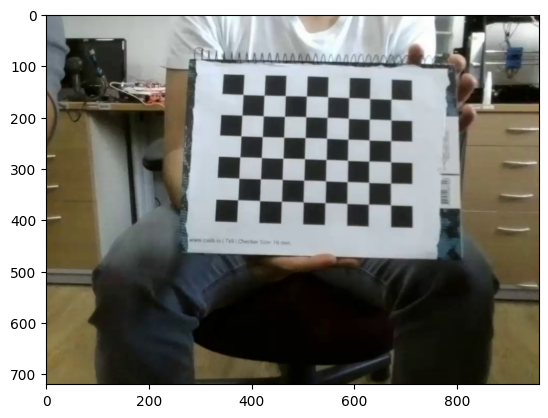

In [7]:
# Exibindo uma das imagens capturadas
image0 = '/home/ramon/projects/computer_vision/images/image0.png'
img = cv2.imread(image0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

A função do OpenCV responsável por encontrar os pontos de interesse nas imagens busca os cantos internos do padrão xadrez. A variável chessBoardSize, abaixo, define o número de cantos internos do padrão utilizado, nesse caso, 8 x 6. Também é definido o tamanho da imagem da câmera, 960 x 720, bem como a variável criteria, que determina o critério de parada para o refinamento dos cantos detectados. Nesse caso, o processo para de refinar após 30 iterações ou quando a precisão de 0,001 é atingida.

In [8]:
# Configurações para a calibração da câmera do drone
chessBoardSize = (8, 6)  # 8 cantos no eixo X, 6 cantos no eixo Y
frameSize = (960, 720)   # Tamanho do frame da câmera

# Critério para o refinamento dos cantos do tabuleiro de xadrez
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

A variável objp define as coordenadas (x, y, z) de cada ponto do tabuleiro no mundo real. Como o tabuleiro é plano, todos os pontos têm z = 0. Esses pontos são usados como referência para comparação com os pontos detectados na imagem.

Já objPoints armazena os pontos 3D no espaço real, enquanto imgPoints armazena os pontos 2D das imagens capturadas, após detecção e refinamento dos cantos.

In [9]:
# Prepara os pontos 3D no mundo real, com (x, y, z) onde z = 0
objp = np.zeros((chessBoardSize[0] * chessBoardSize[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessBoardSize[0], 0:chessBoardSize[1]].T.reshape(-1, 2)

# Arrays para armazenar os pontos 3D e os pontos 2D nas imagens
objPoints = []  # Pontos 3D no espaço real
imgPoints = []  # Pontos 2D nas imagens

Para acessar as imagens facilmente, utilizei glob.glob() para criar uma lista de strings, onde cada string é o caminho para um arquivo .png que corresponde ao padrão capturado.

In [10]:
# Lista de imagens para calibração
images = glob.glob('/home/ramon/projects/computer_vision/images/*.png')

O for abaixo percorre a lista de imagens encontrando os cantos do padrão xadrez em cada uma delas.

In [11]:
for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Encontra os cantos do tabuleiro de xadrez
    ret, corners = cv2.findChessboardCorners(gray, chessBoardSize, None)

    if ret:
        objPoints.append(objp)

        # Refina a localização dos cantos
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgPoints.append(corners2)

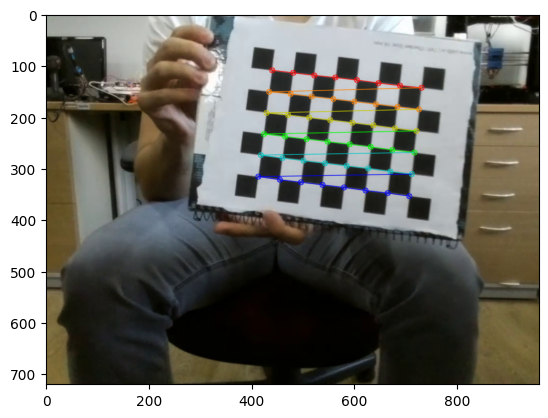

In [12]:
# Exibe os pontos detectados em uma das imagens
img2 = cv2.drawChessboardCorners(img, chessBoardSize, corners2, ret)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

#### 2. Informe os parâmetros intrínsecos da câmera.

Para terminar de calibrar a câmera, basta fornecer para a função cv2.calibrateCamera() os pontos do mundo real e da imagem. Assim, a função retornará a matriz de parâmetros intrínsecos da câmera, bem como outras informações (erro de reprojeção, parâmetros de ditorção.)

In [13]:
repError, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, frameSize, None, None)

# Exibe os resultados da calibração
print("Camera Matrix: \n", cameraMatrix)
print("\nReprojection Error: \n", repError)

Camera Matrix: 
 [[901.10030149   0.         473.03148592]
 [  0.         904.8836646  362.23989375]
 [  0.           0.           1.        ]]

Reprojection Error: 
 0.7866621505915281


#### 3. Utilize os parâmetros de distorção para corrigir as imagens obtidas.

Para remover a distorção de uma imagem obtida por uma câmera calibrada pode-se utilizar a função cv2.undistort, sabendo a matriz de parâmetros intrínsecos e os coeficientes de distorção. 

In [14]:
imagem47 = '/home/ramon/projects/computer_vision/images/image47.png'
img47 = cv2.imread(imagem47)
undistorted_img = cv2.undistort(img47, cameraMatrix, dist)

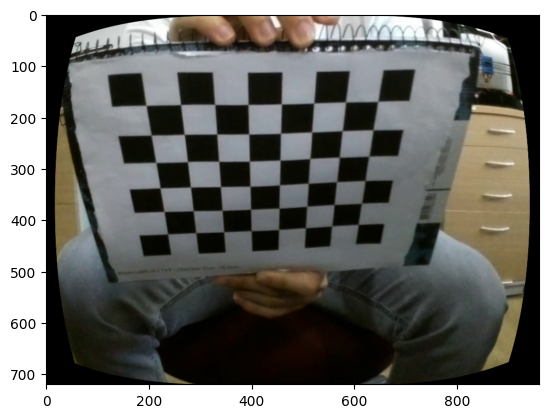

In [15]:
plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))

### Bônus: acrescente uma distorção radial à todas imagens obtidas e observe se a calibração consegue recuperar os valores das constantes

O código abaixo é responsável por distorcer radialmente uma imagem, à depender dos parâmetros k1 e k2 passados para a função.

In [16]:
def radial_distortion(img, k1, k2):
    # Cria uma imagem com as mesmas dimensões da original
    dist_img = np.zeros_like(img, dtype=np.uint8)
    h, w = img.shape[:2]
    center_x, center_y = w // 2, h // 2  # Coordenadas do centro da imagem

    for i in range(h):
        for j in range(w):
            # Coordenadas relativas ao centro da imagem
            x = (j - center_x) / center_x
            y = (i - center_y) / center_y
            r = np.sqrt(x**2 + y**2)

            # Calcula as novas coordenadas com distorção radial
            x_dist = x * (1 + k1 * r**2 + k2 * r**4)
            y_dist = y * (1 + k1 * r**2 + k2 * r**4)

            # Converte as coordenadas de volta para o sistema de pixel
            new_x = int(center_x + x_dist * center_x)
            new_y = int(center_y + y_dist * center_y)

            # Checa se as novas coordenadas estão dentro da imagem
            if 0 <= new_x < w and 0 <= new_y < h:
                dist_img[i, j] = img[new_y, new_x]
            else:
                dist_img[i, j] = 0  # Define preto para pixels fora da imagem

    return dist_img


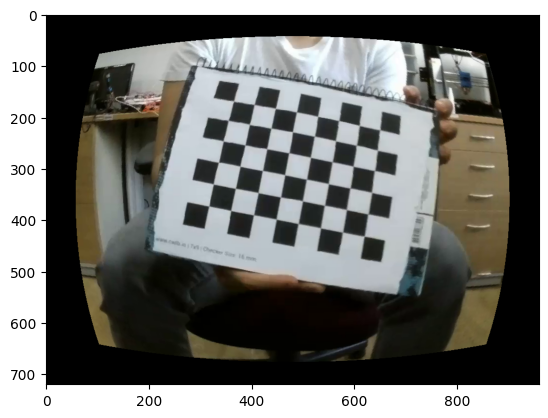

In [17]:
# Aplicando a distorção radial a uma imagem
img5 = cv2.imread('/home/ramon/projects/computer_vision/images/image5.png')
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
distorted_img = radial_distortion(img5, 0.1, 0.1)
plt.imshow(distorted_img)
plt.show()

Aqui é realizado a calibração da câmera novamente.

In [19]:
# Prepara os pontos 3D no mundo real, com (x, y, z) onde z = 0
points3d = np.zeros((chessBoardSize[0] * chessBoardSize[1], 3), np.float32)
points3d[:, :2] = np.mgrid[0:chessBoardSize[0], 0:chessBoardSize[1]].T.reshape(-1, 2)

# Arrays para armazenar os pontos 3D e os pontos 2D nas imagens
objPoints3d = []  # Pontos 3D no espaço real
imgPoints2d = []  # Pontos 2D nas imagens


for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    distorted_img = radial_distortion(gray, 0.1, 0.1)

    # Encontra os cantos do tabuleiro de xadrez
    ret, corners = cv2.findChessboardCorners(distorted_img, chessBoardSize, None)

    if ret:
        objPoints3d.append(points3d)

        # Refina a localização dos cantos
        corners2 = cv2.cornerSubPix(distorted_img, corners, (11, 11), (-1, -1), criteria)
        imgPoints2d.append(corners2)

Como pode ser visto abaixo, os parâmetros obtidos com as imagens distorcidas são os mesmos que foram adquiridos com as imagens sem distorção.

In [21]:
rError, camMatrix, distortion, _, _ = cv2.calibrateCamera(objPoints3d, imgPoints2d, frameSize, None, None)

# Exibe os resultados da calibração
print("Camera Matrix: \n", cameraMatrix)
print("\nReprojection Error: \n", repError)
print("\nDistortion Parameters: \n", distortion)

Camera Matrix: 
 [[901.10030149   0.         473.03148592]
 [  0.         904.8836646  362.23989375]
 [  0.           0.           1.        ]]

Reprojection Error: 
 0.7866621505915281

Distortion Parameters: 
 [[-8.17353209e-01  3.60171296e+00  4.11938292e-02  7.96433154e-03
  -1.11442142e+01]]
